this script is for visualizing the results from the case study

In [291]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [292]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty, game_is_superadditive
from src.nucleolus import get_nucleolus
from src.least_core_nucleolus import get_least_core_nucleolus

In [293]:
def make_game_superadditive(v: dict, players: list) -> dict:
    """
    make game superadditive by adjusting values of coalitions

    v: Characteristic function of the game, must be defined for EVERY coalition
        {frozenset -> float}
    players: list of players
    """
    v_superadd = v.copy()
    for S in powerset(players, exclude_empty=True):
        T = frozenset(players) - S
        union = S.union(T)
        if v_superadd[union] < v_superadd[S] + v_superadd[T]:
            v_superadd[union] = v_superadd[S] + v_superadd[T]
    return v_superadd

In [294]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_13584\536717058.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [ ]:
services = ['FFR-FCR']  # list of services to visualize
dvpps_infos = {}  # dictionary to hold dvpp info dataframes
main_path = 'pics/v_case/'
# other options:
# 'pics/v_case_0604/'
df_expected = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_expected.columns = [tuple(c for c in col if c!='nan') for col in df_expected.columns.values]
df_realized = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
for service in services:
    dvpps_infos[service] = pd.read_csv(f'{main_path}dvpp_info_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

# Reward Split

## Pure-Nucleolus Reward Split

In [296]:
# get reward split of devices
players = [c[0] for c in df_expected.columns if len(c)==1]
idxes = pd.MultiIndex.from_product((df_expected.index.get_level_values(1), ['E-Value', 'E-Nucleolus', 'R-Value', 'R-Nucleolus']))
df_reward_split = pd.DataFrame(0.0, index=idxes, columns=players)
superadditivity_counter = 0
convexity_counter = 0
core_non_empty_counter = 0
for idx, row in df_expected.iterrows():
    # 1. Expected game convert to dictionary
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    # v = make_game_superadditive(v, players)  # ensure superadditivity
    if game_is_superadditive(v, players):
        superadditivity_counter += 1
        nucleolus = get_nucleolus(v, players)
    else:
        print(f"for time {idx[0]}, expected game is not superadditive.")
        print(v)
        nucleolus = get_least_core_nucleolus(v, players)
    if is_convex_game(v, players):
        convexity_counter += 1
    if core_nonempty(v, players):
        core_non_empty_counter += 1
    df_reward_split.loc[(idx[1], 'E-Nucleolus'), list(k for k in nucleolus.keys())] = list(nucleolus.values())
    df_reward_split.loc[(idx[1], 'E-Value'), list(p for p in players)] = [v[frozenset({p})] for p in players]
    # 2. Realized game convert to dictionary
    v_realized = {frozenset(k): val for k, val in df_realized.loc[idx].items()}
    v_realized[frozenset()] = 0.0  # ensure empty set
    nucleolus_realized = get_least_core_nucleolus(v_realized, players)
    df_reward_split.loc[(idx[1], 'R-Nucleolus'), list(k for k in nucleolus_realized.keys())] = list(nucleolus_realized.values())
    df_reward_split.loc[(idx[1], 'R-Value'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]

for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 0.59708, frozenset({'Wind'}): 0.33488, frozenset({'BESS'}): 0.0, frozenset({'PV', 'Wind'}): 0.82446, frozenset({'BESS', 'PV'}): 1.50243, frozenset({'BESS', 'Wind'}): 1.04762, frozenset({'BESS', 'PV', 'Wind'}): 2.03134, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 2.43183, frozenset({'Wind'}): 0.8779, frozenset({'BESS'}): 0.0, frozenset({'PV', 'Wind'}): 3.29936, frozenset({'BESS', 'PV'}): 5.35594, frozenset({'BESS', 'Wind'}): 2.74641, frozenset({'BESS', 'PV', 'Wind'}): 6.34033, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV'}): 5.05568, frozenset({'Wind'}): 0.64284, frozenset({'BESS'}): 0.0, frozenset({'PV', 'Wind'}): 4.90646, frozenset({'BESS', 'PV'}): 9.72388, frozenset({'BESS', 'Wind'}): 2.01105, frozenset({'BESS', 'PV', 'Wind'}): 9.9607, frozenset(): 0.0}
for time FFR-FCR, expected game is not superadditive.
{frozenset({'PV

In [297]:
print(f"For {main_path}, out of {len(df_expected)} games, {superadditivity_counter} superadditive, {convexity_counter} convex and {core_non_empty_counter} non-empty core.") 

For pics/v_case/, out of 117 games, 77 superadditive, 55 convex and 94 non-empty core.


# Reward Split with New Method

In [299]:
from src.game_theory_helpers import evaluate_full_game, solve_optimal_partition

In [300]:
df_rewards = evaluate_full_game(df_expected, df_realized)

In [301]:
hours = df_rewards.index.get_level_values(0).unique()
df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method'].value_counts()

Method
Shapley      55
Nucleolus    39
Sub-Game     23
Name: count, dtype: int64

In [302]:
# new multiindex
idxs1 = df_rewards.index.get_level_values(0).unique().values
idxs2 = df_rewards.index.get_level_values(1).unique().values
idxs3 = df_rewards.index.get_level_values(2).unique().values
idxs2_new = []
for i in idxs2:
    # append idx3
    for j in idxs3:
        idxs2_new.append(f'{i}-{j}')

In [303]:
df_rewards.index = pd.MultiIndex.from_product([idxs1, idxs2_new])

In [355]:
df_median

,Forecasted-Reward,Forecasted-Value,Realized-Reward,Realized-Value
PV,0.40811,0.2817,0.02012,0.0
Wind,5.491715,4.33479,6.160483,5.4424
BESS,3.15776,0.0,2.090555,0.0


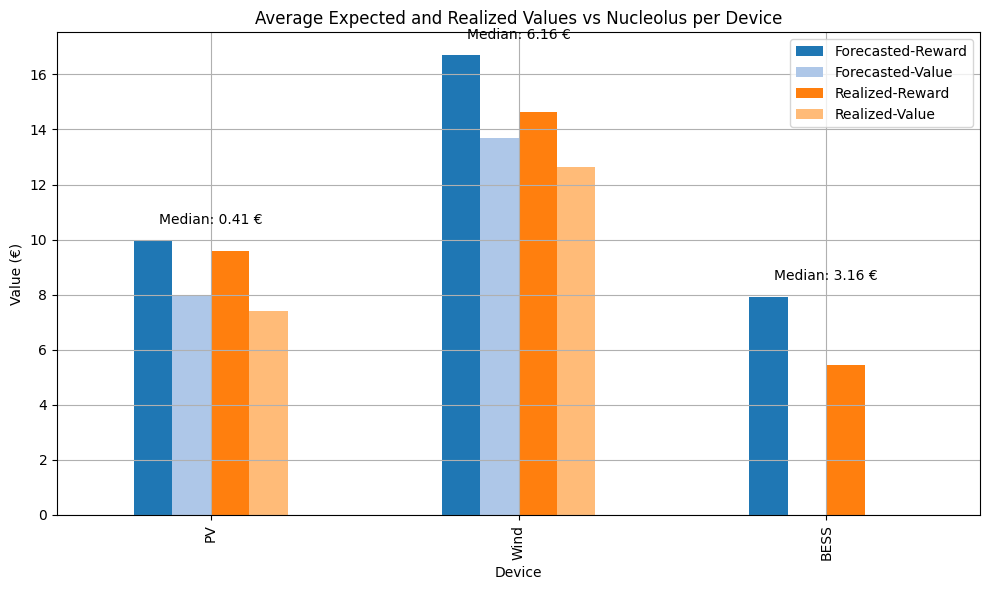

In [ ]:
# plot bar chart
fig, ax = plt.subplots(figsize=(10, 6))

devices = ['PV', 'Wind', 'BESS']
df_plot = df_rewards[devices]
df_mean = df_plot.groupby(level=1).mean()
df_mean = df_mean.transpose()
df_mean.plot.bar(ax=ax)

ax.set_title('Average Expected and Realized Values vs Nucleolus per Device')
ax.set_ylabel('Value (€)')
ax.set_xlabel('Device')
ax.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [364]:
import seaborn as sns

Index(['Forecasted-Value', 'Forecasted-Reward', 'Realized-Value',
       'Realized-Reward'],
      dtype='object')

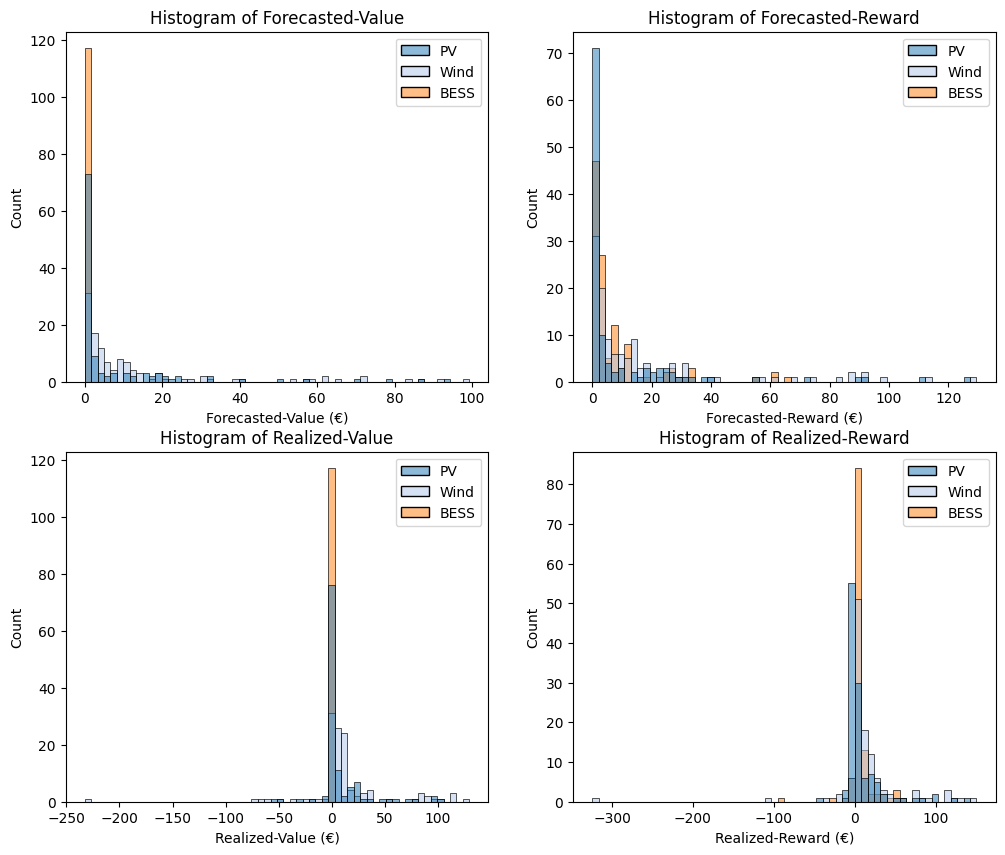

In [373]:
# make 4 subplots axis
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, x in enumerate(df_plot.index.get_level_values(1).unique().values):
    sns.histplot(df_plot.loc(axis=0)[:, x], bins=60, ax=axs[i//2, i%2])
    axs[i//2, i%2].set_title(f'Histogram of {x}')
    axs[i//2, i%2].set_xlabel(f'{x} (€)')

<Axes: >

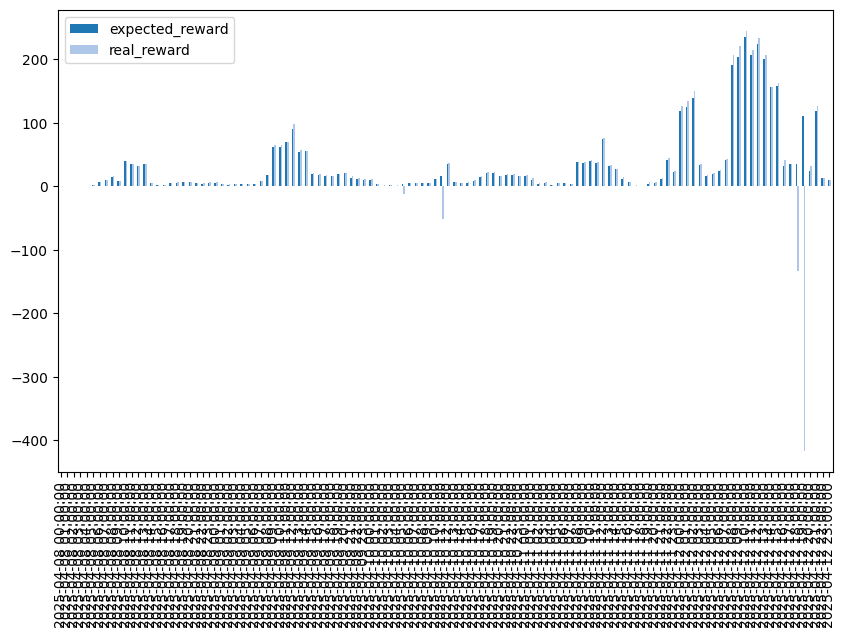

In [305]:
df_exp_real = dvpps_infos[service].groupby(level=0)[['expected_reward', 'real_reward']].mean()
# df_exp_real['diff'] = df_exp_real['real_reward'] - df_exp_real['expected_reward']
df_exp_real.plot.bar(figsize=(10,6))

### Analyze the Sub-game cases

In [306]:
from src.get_optimal_bid import get_optimal_bid
import numpy as np

In [307]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")
# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]
# Create extended cycle: first full alpha, then alpha=0.5
# colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]
# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\pasca\AppData\Local\Temp\ipykernel_13584\216728504.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [308]:
# load bids dataframe
df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

In [309]:
idxs_sg = df_rewards[df_rewards['Method']=='Sub-Game'].index.get_level_values(0).unique()

In [310]:
idxs_sg

Index([  7,  11,  12,  28,  31,  33,  35,  38,  40,  54,  59,  61,  75,  77,
        79,  80,  83,  85,  86, 104, 105, 106, 107],
      dtype='int64')

In [311]:
def map_idx_to_datetime(idx):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    return pd.Timestamp(vals[idx])
def map_datetime_to_idx(dt):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    for i, v in enumerate(vals):
        if v == dt:
            return i
    return None

In [312]:
def bid_value(bids, rho, bid,
              return_prob=False):
    gamma = sum(rho for b in bids if b >= bid)
    if return_prob:
        return gamma
    return bid * (4 * gamma - 3)

In [313]:
def bids_to_values(bids, rho, return_prob=False) -> np.ndarray:
    values = np.array([bid_value(bids, rho, b, return_prob=False) for b in bids])
    if not return_prob:
        return values
    else:
        gammas = np.array([bid_value(bids, rho, b, return_prob=True) for b in bids])
        return gammas, values

In [314]:
dt_idxs = [map_idx_to_datetime(i) for i in idxs_sg]

In [315]:
cols = df_bids.columns
idx_tuples = [eval(col) for col in df_bids.columns.values]
idx_frozensets = [frozenset(tup) for tup in idx_tuples]
the_map = {fs: col for fs, col in zip(idx_frozensets, cols)}

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 07:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 10.366719999999999.
Coalition frozenset({'Wind'}) max value at index 2, bid: 0.536, value: 0.321
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.862, value: 4.862
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 4.980, value: 4.980


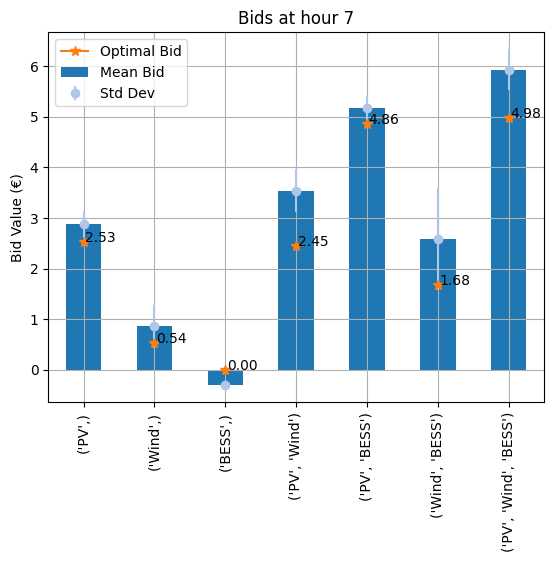

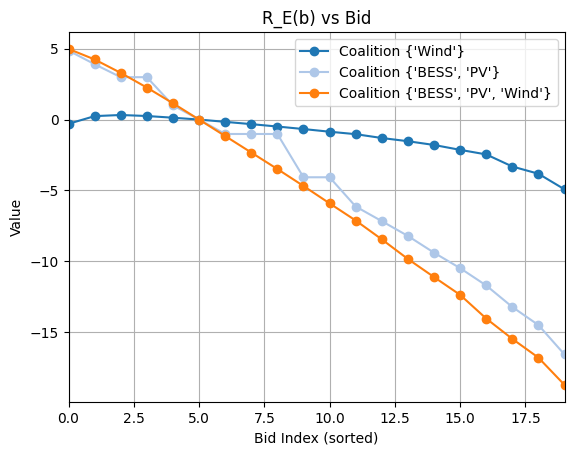

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 11:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 37.30278.
Coalition frozenset({'Wind'}) max value at index 1, bid: 0.701, value: 0.561
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.656, value: 5.656
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 5.872, value: 5.872


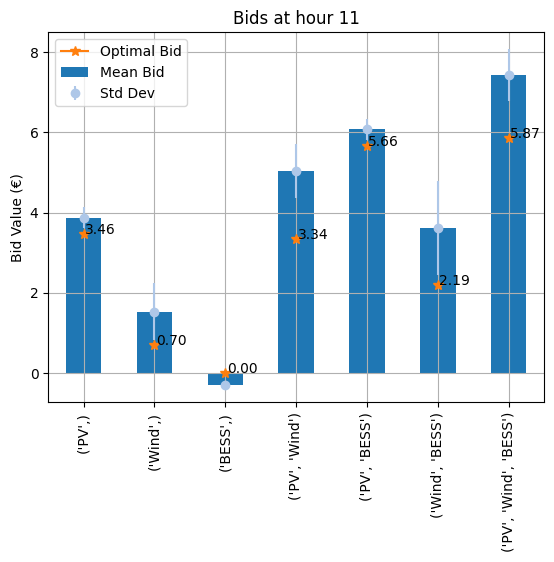

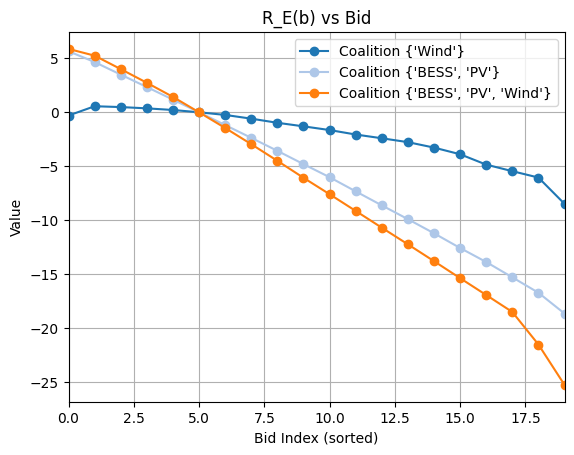

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-08 12:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 33.6589.
Coalition frozenset({'Wind'}) max value at index 2, bid: 0.382, value: 0.229
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.380, value: 5.380
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 5.380, value: 5.380


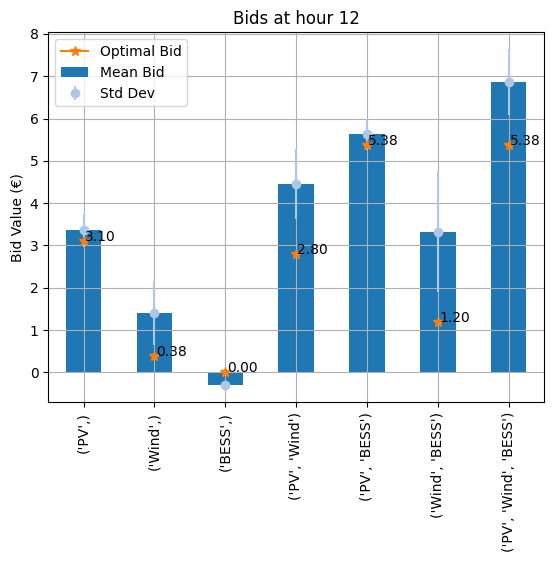

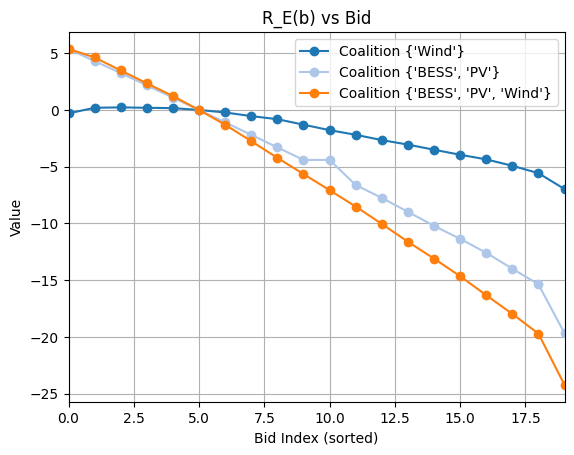

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 04:00:00, optimal partition is [frozenset({'BESS', 'Wind'}), frozenset({'PV'})] with value 3.2726699999999997.
Coalition frozenset({'BESS', 'Wind'}) max value at index 0, bid: 6.409, value: 6.409
Coalition frozenset({'PV'}) max value at index 1, bid: 0.171, value: 0.137
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 6.453, value: 6.453


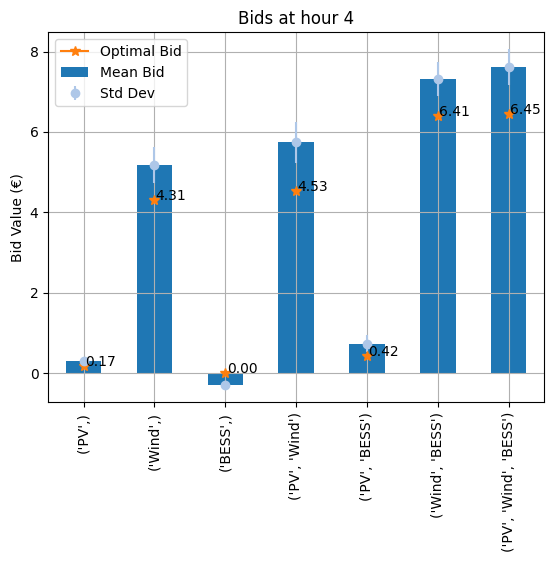

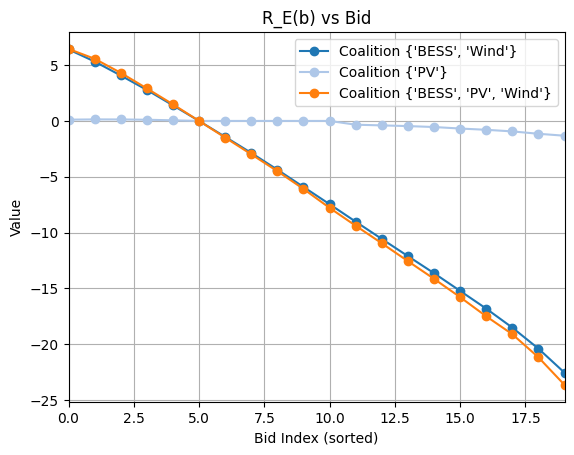

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 07:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 8.78752.
Coalition frozenset({'Wind'}) max value at index 0, bid: 4.335, value: 4.335
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.453, value: 4.453
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 8.527, value: 8.527


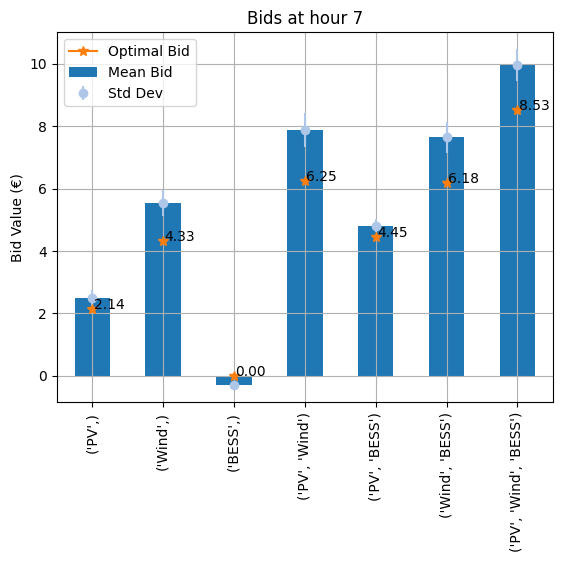

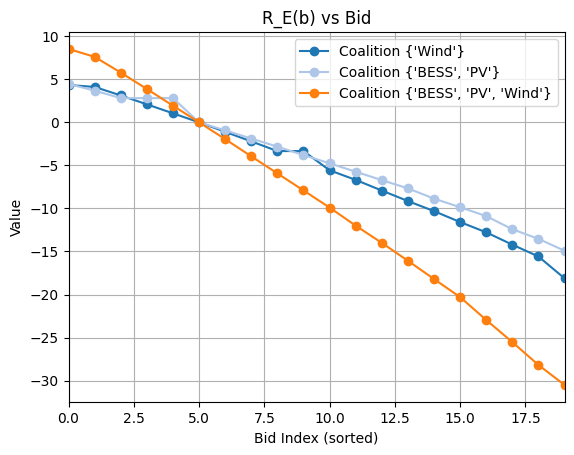

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 09:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 62.673.
Coalition frozenset({'Wind'}) max value at index 0, bid: 5.238, value: 5.238
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.234, value: 5.234
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 10.374, value: 10.374


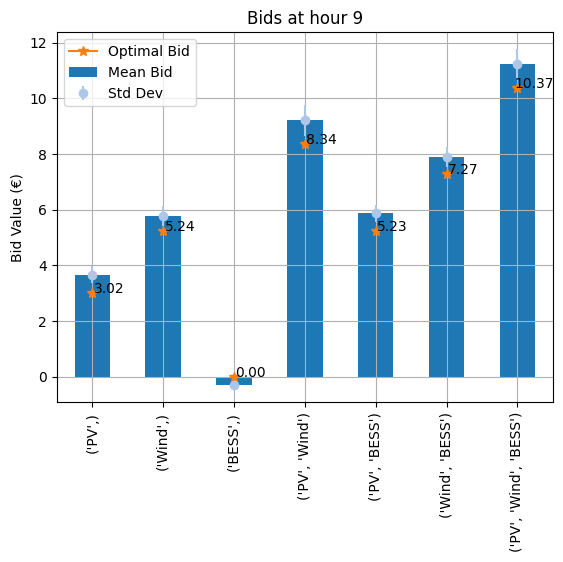

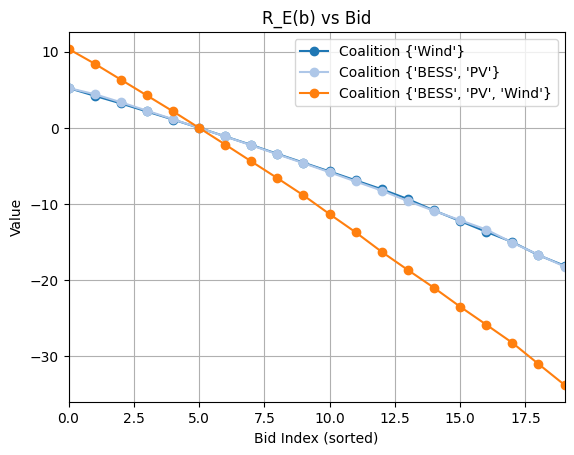

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 11:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 70.7044.
Coalition frozenset({'Wind'}) max value at index 0, bid: 4.508, value: 4.508
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.593, value: 5.593
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 10.020, value: 10.020


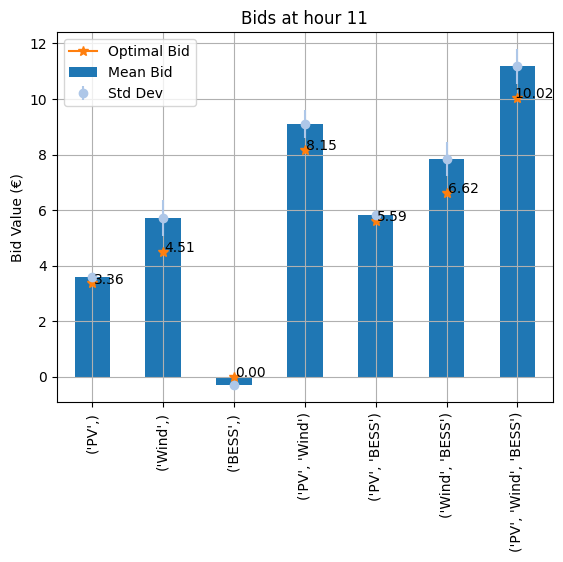

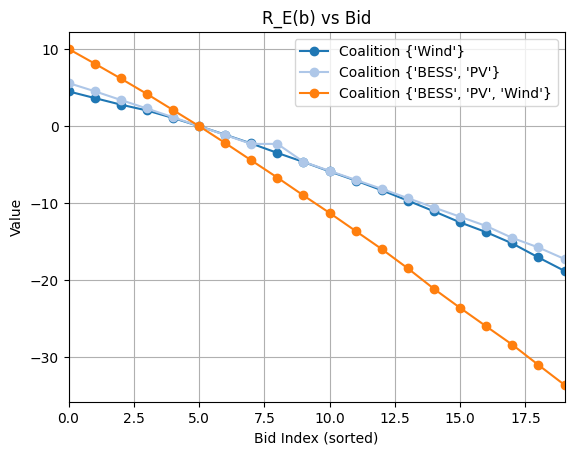

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 14:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 56.947779999999995.
Coalition frozenset({'Wind'}) max value at index 0, bid: 5.011, value: 5.011
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.101, value: 4.101
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 8.846, value: 8.846


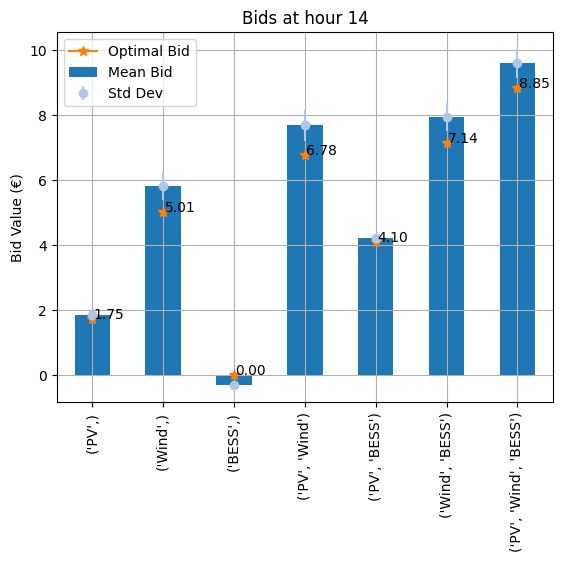

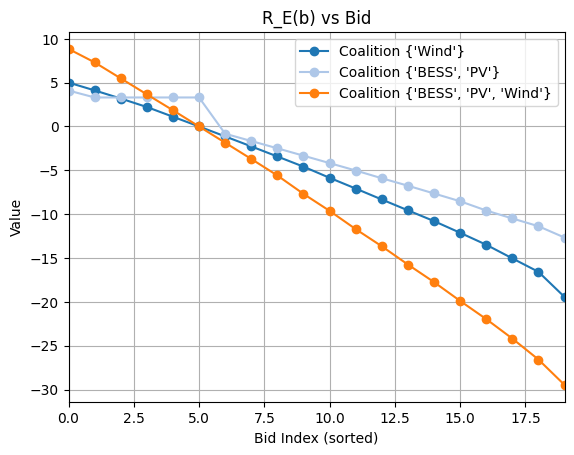

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 16:00:00, optimal partition is [frozenset({'BESS', 'Wind'}), frozenset({'PV'})] with value 17.56902.
Coalition frozenset({'BESS', 'Wind'}) max value at index 0, bid: 6.713, value: 6.713
Coalition frozenset({'PV'}) max value at index 0, bid: 0.343, value: 0.343
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 7.011, value: 7.011


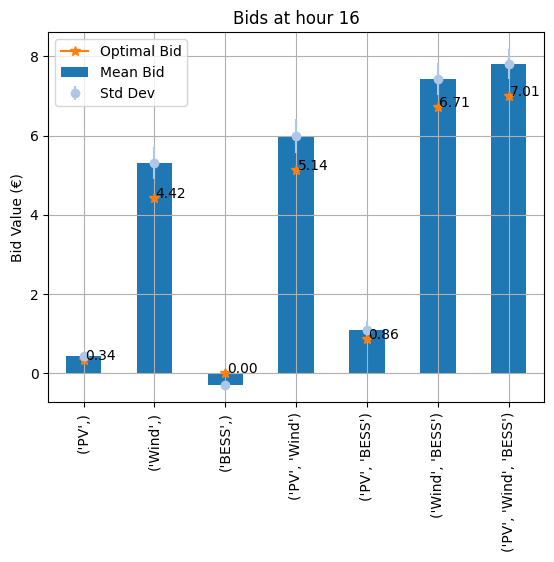

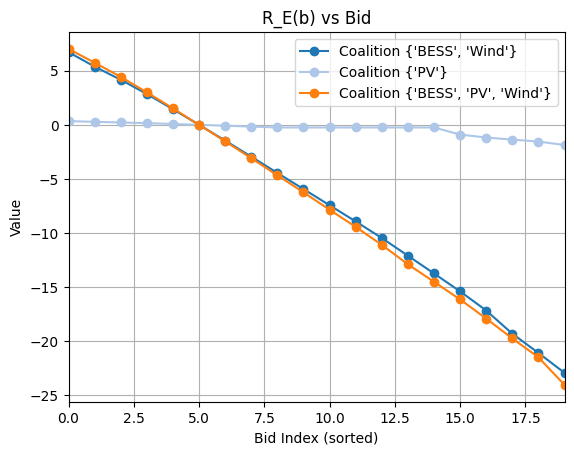

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 06:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 5.83205.
Coalition frozenset({'Wind'}) max value at index 2, bid: 0.303, value: 0.182
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.484, value: 4.484
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 4.552, value: 4.552


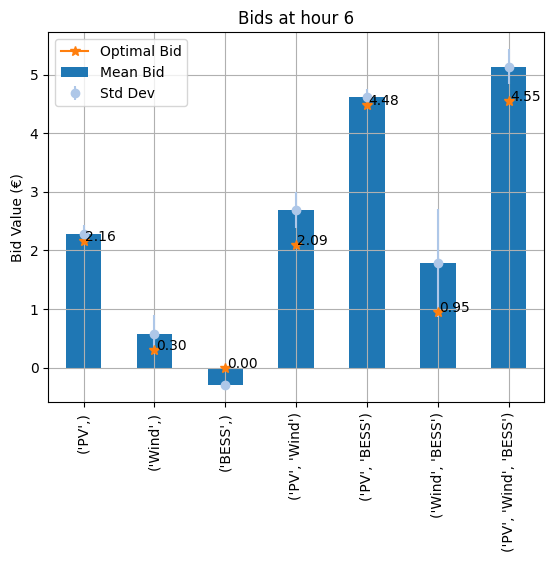

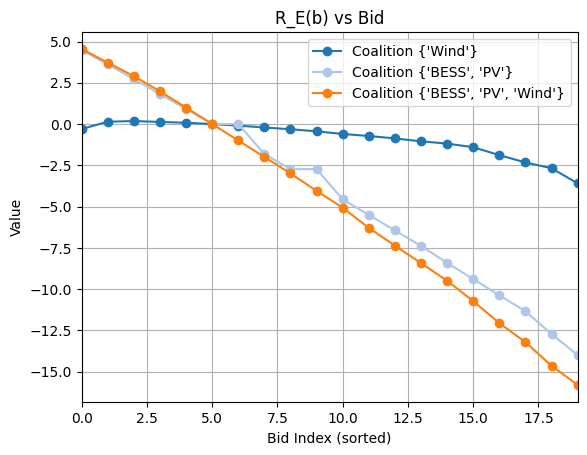

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 11:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 17.611359999999998.
Coalition frozenset({'Wind'}) max value at index 3, bid: 0.642, value: 0.257
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.633, value: 5.633
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 5.699, value: 5.699


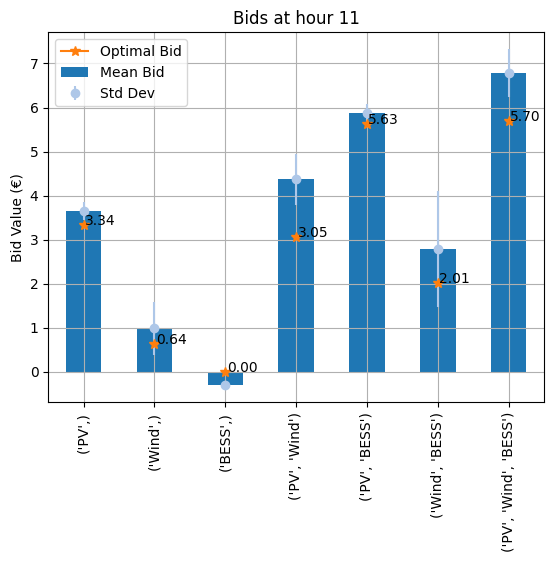

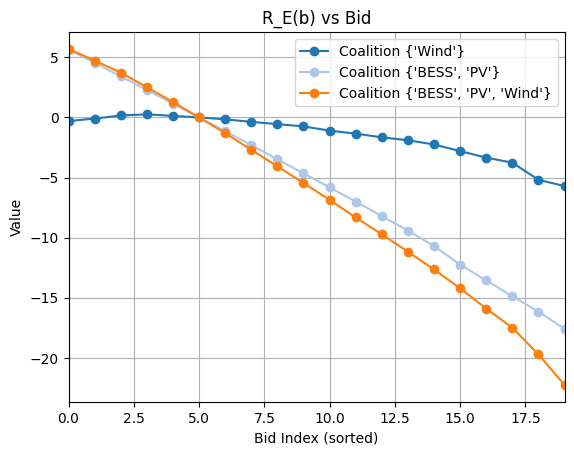

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-10 13:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 6.58089.
Coalition frozenset({'Wind'}) max value at index 0, bid: 0.851, value: 0.851
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.414, value: 4.414
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 5.168, value: 5.168


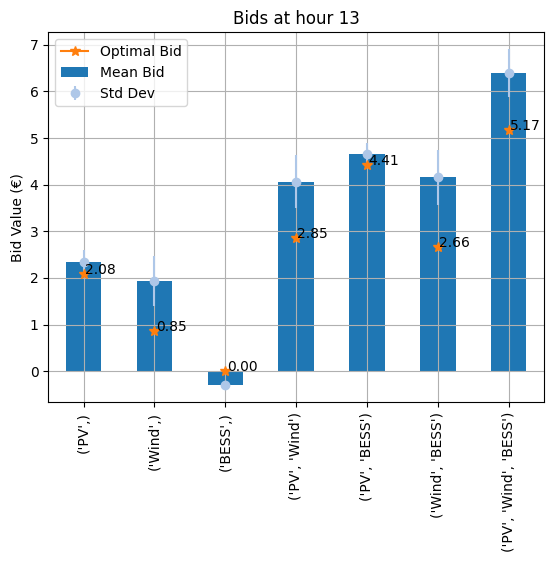

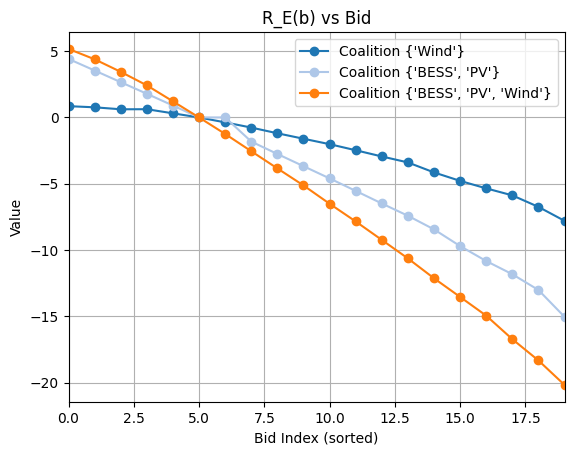

Bids are invalid (max bid: 0.168, mean bid: -0.253), submitting 0 bid (not participating).
Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.412, mean bid: -0.229), submitting 0 bid (not participating).
At hour 2025-04-11 03:00:00, optimal partition is [frozenset({'BESS', 'Wind'}), frozenset({'PV'})] with value 6.13368.
Coalition frozenset({'BESS', 'Wind'}) max value at index 0, bid: 4.907, value: 4.907
Coalition frozenset({'PV'}) max value at index 0, bid: -0.300, value: -0.300
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 4.749, value: 4.749


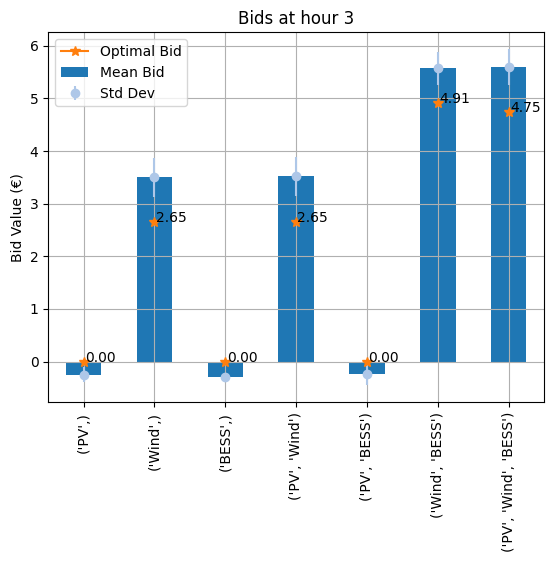

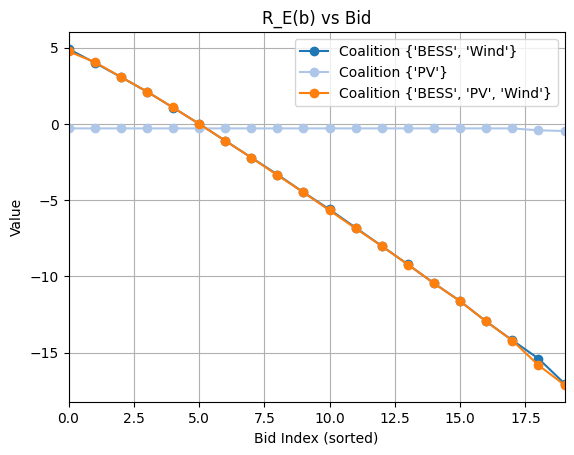

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 05:00:00, optimal partition is [frozenset({'BESS', 'Wind'}), frozenset({'PV'})] with value 4.7914.
Coalition frozenset({'BESS', 'Wind'}) max value at index 0, bid: 4.152, value: 4.152
Coalition frozenset({'PV'}) max value at index 0, bid: 0.639, value: 0.639
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 4.711, value: 4.711


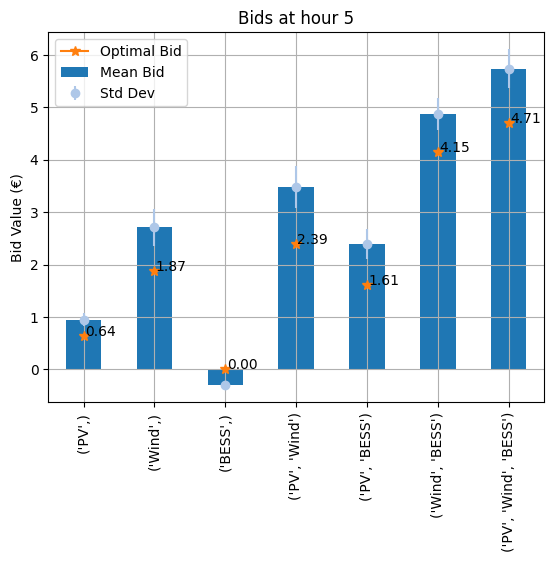

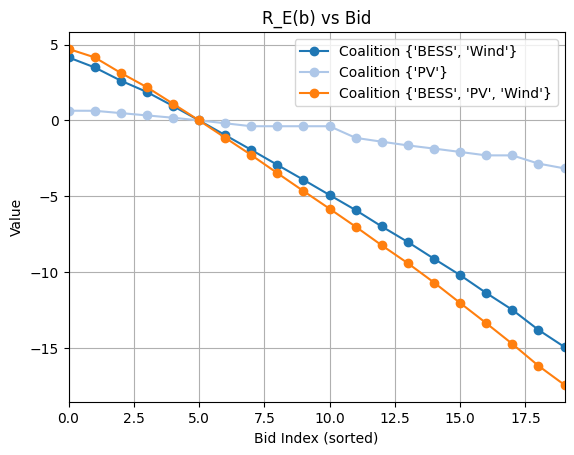

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 07:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 4.12088.
Coalition frozenset({'Wind'}) max value at index 2, bid: 1.503, value: 0.902
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.249, value: 4.249
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 4.782, value: 4.782


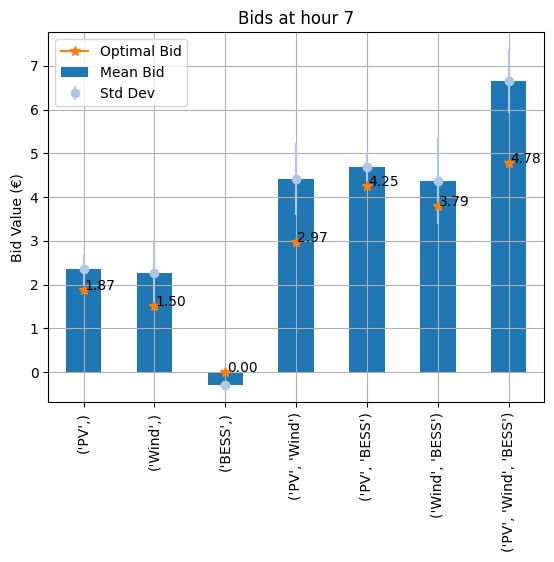

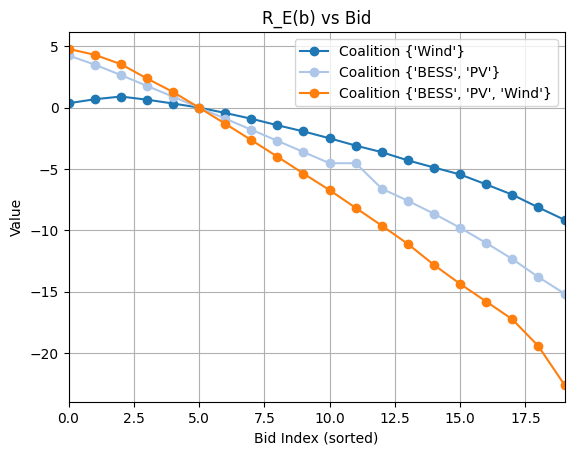

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 08:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 40.090720000000005.
Coalition frozenset({'Wind'}) max value at index 1, bid: 1.992, value: 1.593
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.873, value: 4.873
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 6.163, value: 6.163


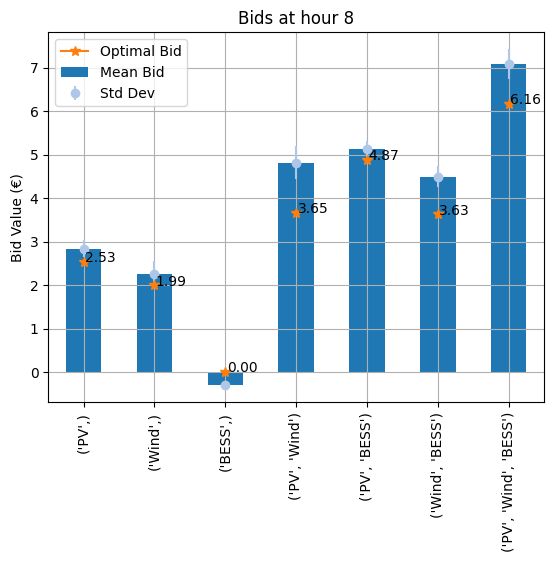

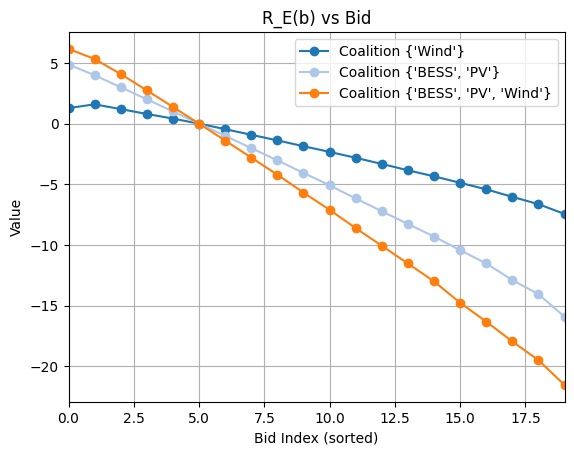

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 11:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 38.21645.
Coalition frozenset({'Wind'}) max value at index 1, bid: 0.923, value: 0.738
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.376, value: 5.376
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 5.861, value: 5.861


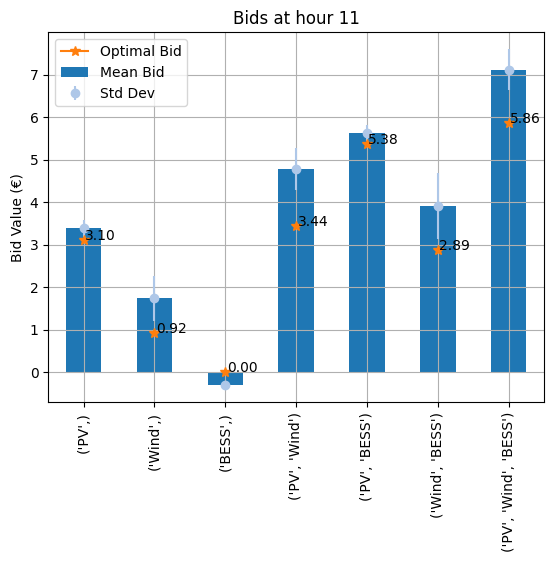

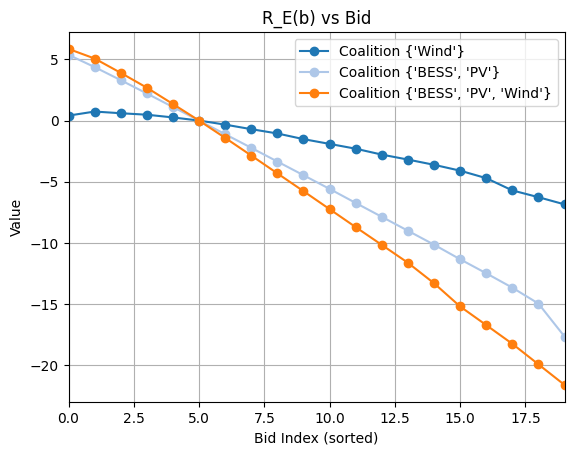

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 13:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 32.54763.
Coalition frozenset({'Wind'}) max value at index 2, bid: 1.019, value: 0.611
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.813, value: 4.813
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 5.327, value: 5.327


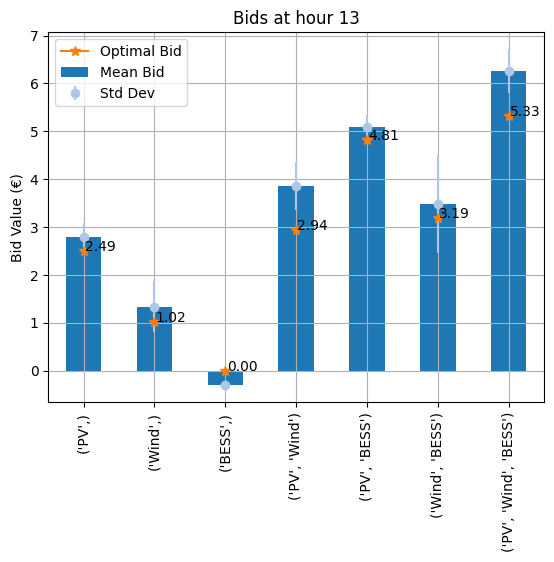

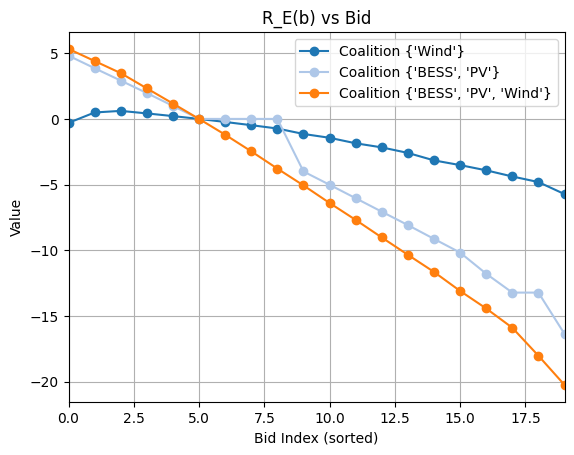

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-11 14:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 27.961190000000002.
Coalition frozenset({'Wind'}) max value at index 2, bid: 0.576, value: 0.345
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.164, value: 4.164
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 4.314, value: 4.314


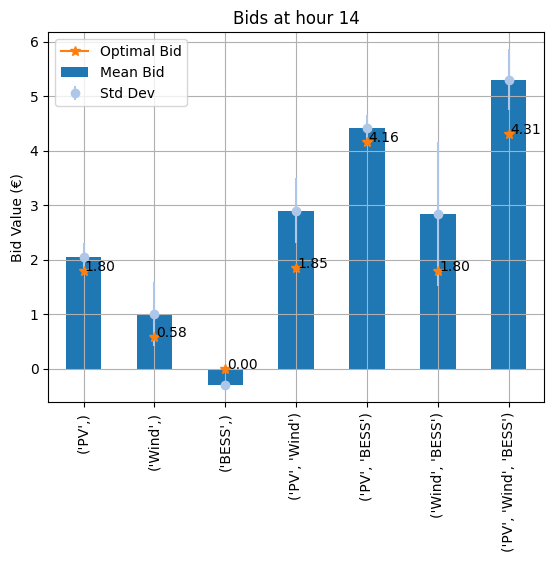

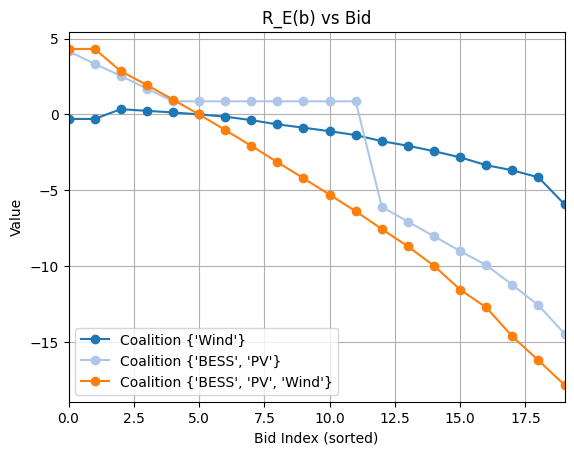

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 08:00:00, optimal partition is [frozenset({'BESS', 'Wind'}), frozenset({'PV'})] with value 199.82367000000002.
Coalition frozenset({'BESS', 'Wind'}) max value at index 0, bid: 5.616, value: 5.616
Coalition frozenset({'PV'}) max value at index 1, bid: 1.768, value: 1.415
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 6.753, value: 6.753


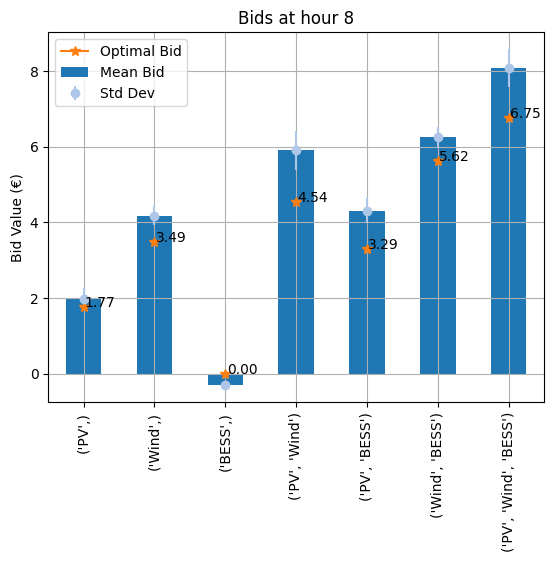

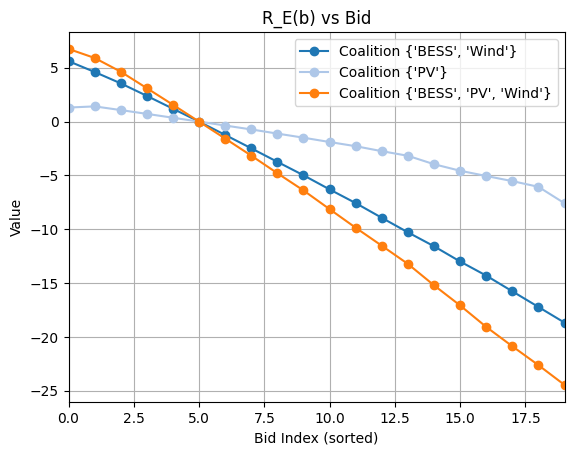

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 09:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 208.61282.
Coalition frozenset({'Wind'}) max value at index 0, bid: 2.919, value: 2.919
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 4.413, value: 4.413
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 7.171, value: 7.171


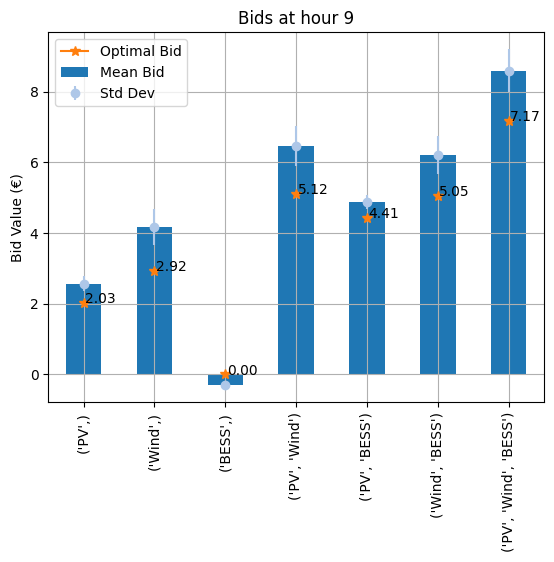

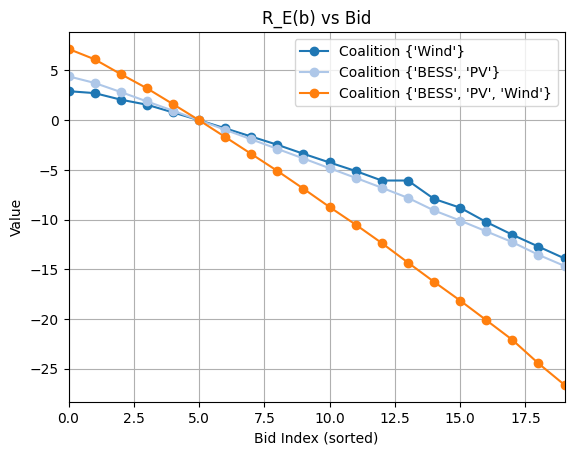

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 10:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 236.92938999999998.
Coalition frozenset({'Wind'}) max value at index 0, bid: 3.224, value: 3.224
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.031, value: 5.031
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 8.184, value: 8.184


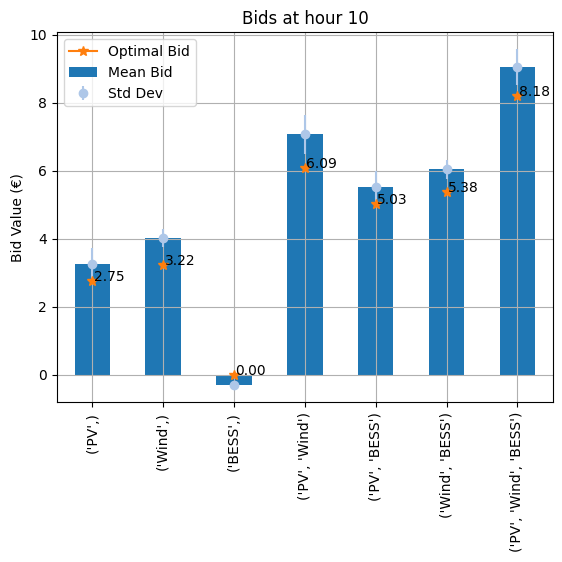

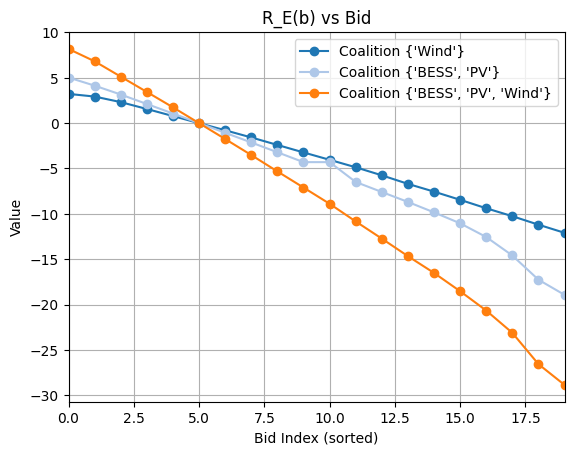

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-12 11:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 215.16870999999998.
Coalition frozenset({'Wind'}) max value at index 1, bid: 2.497, value: 1.998
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.566, value: 5.566
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 7.287, value: 7.287


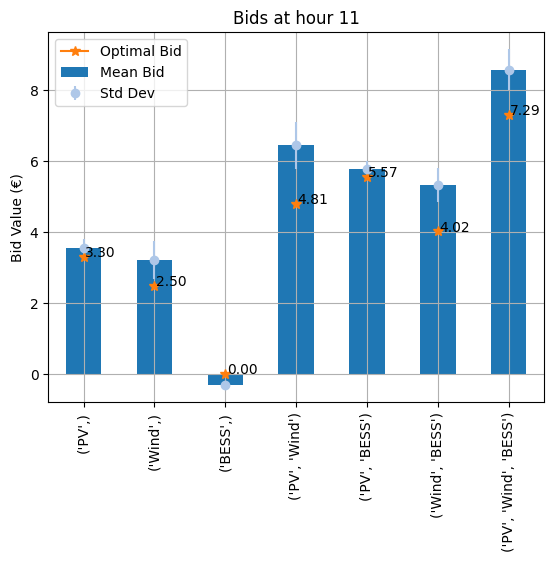

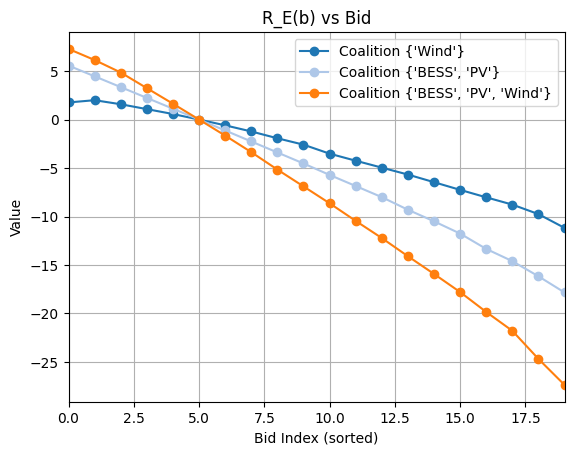

In [316]:
K_errors = len(df_bids.loc[dt_idxs[0]])
probs = [1/K_errors for _ in range(K_errors)]
for dt in dt_idxs:
    # print(dvpps_infos[service].loc[dt])
    # visualize mean and std of each column
    plt.figure()
    plt.title(f'Bids at hour {dt.hour}')
    df_bids.loc[dt].mean(axis=0).plot(kind='bar', label='Mean Bid')
    # plot min max with error bars
    plt.errorbar(x=df_bids.loc[dt].columns, y=df_bids.loc[dt].mean(axis=0), yerr=df_bids.loc[dt].std(axis=0), fmt='o', label='Std Dev',
                 color=base_colors[1])
    # compute optimal bid for each coalition and plot as star marker
    dict_opt_bids = {}
    for coalition in df_bids.loc[dt].columns:
        c_bids = np.squeeze(df_bids.loc[dt, [coalition]].values)
        b_star_coalition, value_wo_price, gamma = get_optimal_bid(c_bids, probs, return_reward=True)
        dict_opt_bids[coalition] = b_star_coalition
        # plot as star marker
        plt.plot(coalition, b_star_coalition, marker='*', markersize=7, label='Optimal Bid' if coalition==df_bids.loc[dt].columns[0] else "", color=base_colors[2])
        # annotate value of optimal bid to the right of the star
        plt.annotate(f'{b_star_coalition:.2f}', (coalition, b_star_coalition), textcoords="offset points", xytext=(12, 0), ha='center', fontsize=10)
    plt.ylabel('Bid Value (€)')
    plt.grid()
    plt.legend()

    # next, also plot th eindividual bids in line chart for non-superadditiv coalitions
    v = {frozenset(k): val for k, val in df_expected.loc[(service, map_datetime_to_idx(dt))].items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    max_value, coalitions = solve_optimal_partition(v)
    print(f'At hour {dt}, optimal partition is {coalitions} with value {max_value}.')
    # plot line chart for this coalition
    plt.figure()
    x_ks = np.arange(K_errors)
    # add grand coalition
    coalitions.append(frozenset(players))

    for coalition in coalitions:
        # convert to columns
        col = the_map[coalition]
        the_bids = df_bids.loc[dt, col].values.tolist()
        the_bids.sort()
        # the_bids = the_bids[::-1]
        # convert bids to values
        vals = bids_to_values(the_bids, probs[0])
        # indicate dict_opt_bids in plot
        plt.plot(x_ks, vals, marker='o', label=f'Coalition {set(coalition)}')

        # print idx and bid of max value
        # max_idx = np.argmax(added_vals)
        max_idx = np.argmax(vals)
        print(f"Coalition {coalition} max value at index {max_idx}, bid: {the_bids[max_idx]:.3f}, value: {vals[max_idx]:.3f}")
        # max_idx_1 = np.argmax(vals)
        # print(f"Max value set 1 at index {max_idx_1}, bid: {bids[max_idx_1]:.3f}, value: {vals[max_idx_1]:.3f}")
        # max_idx_2 = np.argmax(vals_2)
        # print(f"Max value set 2 at index {max_idx_2}, bid: {bids_2[max_idx_2]:.3f}, value: {vals_2[max_idx_2]:.3f}")
        # print(f"Difference of Max: bid12 - (bid1 + bid2)={added_bids[max_idx] - (bids[max_idx_1] + bids_2[max_idx_2]):.6f}, value12 - (value1 + value2)={added_vals[max_idx] - (vals[max_idx_1] + vals_2[max_idx_2]):.6f}")
                
        # plt.axhline(y=dict_opt_bids[col], linestyle='--', label='Optimal Bid' if coalition==coalitions[0] else "")

    # plt.plot(x_ks, vals, marker='o', label='Wind')
    # plt.plot(x_ks, vals_2, marker='x', label='PV')
    # plt.plot(x_ks, added_vals, marker='s', label='Wind + PV')
    # plt.plot(x_ks, diff, marker='d', label='Difference')
    plt.xlabel('Bid Index (sorted)')
    plt.ylabel('Value')
    plt.title('R_E(b) vs Bid')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, K_errors-1)
    plt.show()

    